In [3]:
#All the imports we will need
import math
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from matplotlib import pyplot as plt
import gc
import time
import tracemalloc

#Custom files
from logP import *
from get_pyrosetta_scores import get_pyrosetta_scores_from_sequence
from bmDCA import *

/home/joseph/summer2020_personal/Bayesian_Optimization/utils.py:2: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.loops.loop_closure.kinematic_closure import *


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
[Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', 

In [65]:
#Mock experimental functionality score, currently higher is better                                                                                   
def hammingDist(str1, str2): 
    count = 0 
    for i in range(len(str1)):
        if(str2[i] != str1[i]):
            count+=1
    return count/len(str1)



In [69]:
"""

scalarization of objectives (y) sum of coefficients equals one will minimize "cost" 
calculate scalarized cost for a single y value 

"""
#objects below to assist in consistent scoring and sequence finding
vae = VAE_Operator()
dca = DCA_scorer()

def standardize_multi_dimensional_cost(y_):
    """
        standardizes scores to mean 0, and range -1 to 1
        
        inputs: multi dim score list
        returns: standardize score list
    
    """
    y_standardized = np.array(y_)
    for i in range(len(y_standardized[0])):
        mean = np.mean(y_standardized[:,i])
        std = np.std(y_standardized[:,i])
        y_standardized[:,i] = (y_standardized[:,i]-mean)/std
    return y_standardized
        

def multi_dimensional_cost(x):
    """
        scores point x on four metrics (vae, pyr, dca, functionality)
        ~Important: BO set up to minimize~
        
        inputs: point x (vae latent encoding)
        returns: list of scores [vae, pyr cost, dca, functionality] and new sequence tested
    """
    sequence = vae.get_seq_from_z(x)
    vae_prob = vae.get_score_from_z(x)[0] 
    pyr_score = get_pyrosetta_scores_from_sequence(sequence)
    dca_prob = dca.get_dca_scores_from_seq(sequence)[0] 
    functionality_prob = hammingDist("A"*62, sequence)
    return ([vae_prob*(-1), pyr_score, dca_prob*(-1), functionality_prob*(-1)], sequence)

def scalarized_cost(y_singular,lambda_,rho=0.05):
    """
        scalarizes a single multidimensional (4) score list by some normalized lambda_
        
        inputs: y_singular=a 4 length score array, lambda_=a normalized random vector for bayesian optimization, rho=hyperparameter for tuning
        returns: a single scaralized score
    """
    lambda_ /= np.sum(lambda_)
    p = np.multiply(y_singular, lambda_)
    return np.max(p) + np.sum(p * rho)

def calc_scal_from_observations(y):
    """
        calc scalarized cost for entire run based on scalarized lambda
        
        inputs: np.array of all y scores {(nx4) generally}
        returns: a 1d np.array of scaralized scores for 
    """
    lambda_ = np.random.random(len(y[0]))
    lambda_ /= np.sum(lambda_)
    scalar_scores = np.zeros(len(y))
    y_standardized = standardize_multi_dimensional_cost(y)
    for counter, y_singular in enumerate(y_standardized):
        cost = scalarized_cost(y_singular, lambda_)
        scalar_scores[counter] = cost
    return (scalar_scores, lambda_)

#expected improvement (to be maximized across whole x_space)
def EI(muNew, stdNew, fMax, epsilon=0.01):
    """
    Expected improvement acquisition function
    INPUT:
    - muNew: mean of predicted point in grid
    - stdNew: sigma (square root of variance) of predicted point in grid
    - fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
    - epsilon: trade-off parameter (>=0)
    [Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])
    OUTPUT:
    - EI: expected improvement for candidate point
    As describend in:
    E Brochu, VM Cora, & N de Freitas (2010):
    A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
    arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
    """

    Z = (muNew - fMax - epsilon) / stdNew

    return (muNew - fMax - epsilon) * scipy.stats.norm.cdf(
        Z
    ) + stdNew * scipy.stats.norm.pdf(Z) * (-1)



# BO Minimizes # 
The current build **min

In [70]:
class BO():
    def __init__(self, initial_x, initial_y):
        self.model = GaussianProcessRegressor()
        self.observed_x = initial_x
        self.observed_y = initial_y
        self.observed_y_scalarized, _ = calc_scal_from_observations(self.observed_y)
        self.model.fit(self.observed_x, self.observed_y_scalarized)
        self.average_scores = np.zeros(1)
        self.sequences = []

        
    def propose_new(self, resolution=1000000, dim=3):
        best = np.max(self.observed_y_scalarized)
        
        #with sigma^2 equal to 0.75^2, generate a bunch of random sequences to maximize acq
        x_space = 0.75*np.random.randn(resolution,dim)
        
        mu, std = self.model.predict(x_space, return_std = True)
        #evaluate ei at a bunch of points in x_space
        scores = EI(mu, std, best)
        #maximize ei
        max_i = np.argmax(scores) 
        new_point = x_space[max_i]
        print(new_point, "-suggested new point")
        return new_point
    
    
    def run_BO(self, num_iter=10):
        start_t = time.time()
        time.clock()    
        self.average_scores = np.zeros((num_iter, len(self.observed_y[0])))
        for num_round in range(num_iter):
            #trace memory
            tracemalloc.start()
            
            #1) calculate random scalarization for this round
            self.observed_y_scalarized, lambda_ = calc_scal_from_observations(self.observed_y)
            
            #2) Fit GPR to this scalarization
            self.model.fit(self.observed_x, self.observed_y_scalarized)
            
            #plot current round
            plt.plot(range(len(self.observed_y_scalarized)), self.observed_y_scalarized)
            plt.xlabel("Number of Sequences Tested by BO")
            plt.ylabel("Scalarized Scores (different scalarization each round)")
            plt.title("Round "+ str(num_round)+ " Scalarized Score Plot")
            plt.show()
            print("Round ", num_round, " mean score: ", np.mean(self.observed_y_scalarized))
            print("Random Scalarization (Lambda): ", lambda_)

            #3) Propose new point
            new_point_to_check = self.propose_new()
            
            #4) Score new point
            self.observed_x = np.vstack([self.observed_x, new_point_to_check])
            new_score, new_sequence = multi_dimensional_cost(new_point_to_check)
            self.sequences += [new_sequence]
            self.observed_y = np.vstack([self.observed_y, new_score])
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            print("Peak Memory Used This Round: ", peak)
            
            #5) Calculate average scores for analysis
            for i in range(len(self.observed_y[0])):
                self.average_scores[num_round][i] = np.mean(self.observed_y[:,i])
            print((1.0- num_round/num_iter) * (time.time()-start_t)/(num_round+1))
            print("ETA: ", int((num_iter-num_round) * (time.time()-start_t)/(num_round+1)), " seconds")
            print("------------------------------------------------------------------------")
            print()
            gc.collect()
            np.savetxt("data/round"+str(num_round)+"_observed_points.txt", self.observed_x)
            np.savetxt("data/round"+str(num_round)+"_observed_scores.txt", self.observed_y)


In [74]:
#initialize 5 random points
initial_x = np.random.randn(3,3)

initial_scores = []
initial_sequences = []
for i in initial_x:
    nscore, nseq = multi_dimensional_cost(i)
    initial_sequences += [nseq]
    initial_scores += [nscore]

initial_y = np.array(initial_scores)


In [75]:
bayesian_optimizer = BO(initial_x, initial_y)

/home/joseph/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


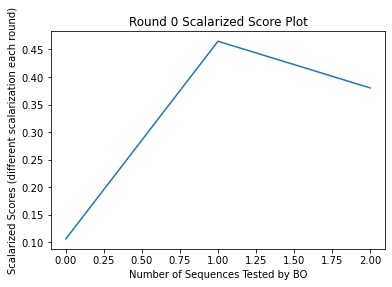

Round  0  mean score:  0.3170482954133858
Random Scalarization (Lambda):  [0.17469712 0.31972854 0.22708145 0.27849289]
[-0.04579124 -0.02038551 -0.3915696 ] -suggested new point
Peak Memory Used This Round:  125343076
4.3817102909088135
ETA:  131  seconds
------------------------------------------------------------------------



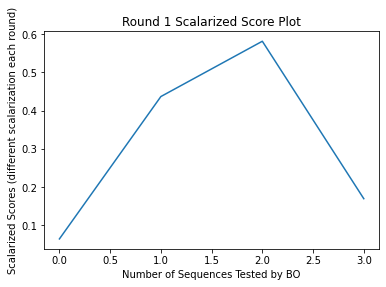

Round  1  mean score:  0.3128271554237462
Random Scalarization (Lambda):  [0.07241107 0.24368284 0.34397996 0.33992613]
[ 0.14061875  0.94602618 -0.5210482 ] -suggested new point
Peak Memory Used This Round:  152707703
3.9511006315549215
ETA:  118  seconds
------------------------------------------------------------------------



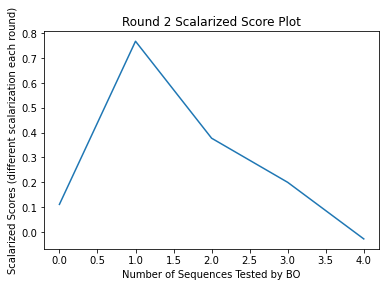

Round  2  mean score:  0.28530145665352674
Random Scalarization (Lambda):  [0.15191343 0.37720976 0.27474191 0.19613489]
[ 0.0729884   0.41262184 -0.58114735] -suggested new point
Peak Memory Used This Round:  184824097
4.198478455013699
ETA:  125  seconds
------------------------------------------------------------------------



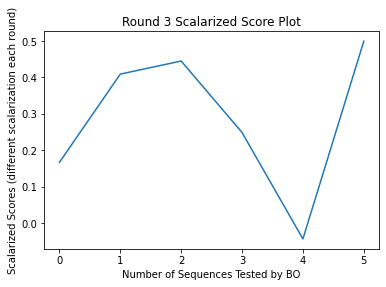

Round  3  mean score:  0.28734591807569887
Random Scalarization (Lambda):  [0.27602878 0.09229442 0.29601736 0.33565945]
[-0.1043892   0.59604643  0.44307347] -suggested new point
Peak Memory Used This Round:  216686417
4.140742135047913
ETA:  124  seconds
------------------------------------------------------------------------



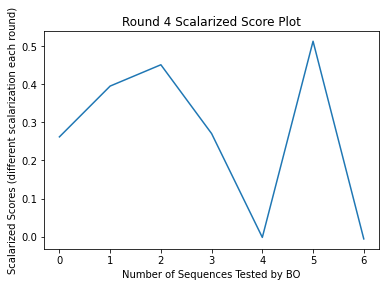

Round  4  mean score:  0.2689325437037339
Random Scalarization (Lambda):  [0.3446602  0.10005127 0.24957317 0.30571535]
[ 0.1842954   0.27098207 -1.01184635] -suggested new point
Peak Memory Used This Round:  248708601
4.17713796933492
ETA:  125  seconds
------------------------------------------------------------------------



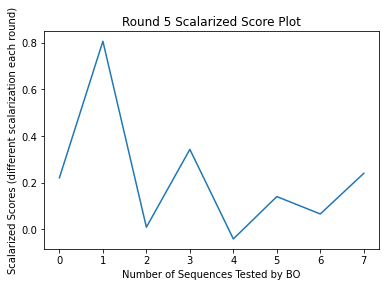

Round  5  mean score:  0.22313749234195832
Random Scalarization (Lambda):  [0.31502283 0.30130916 0.36124591 0.02242211]
[ 0.22416874  2.19616231 -0.51935709] -suggested new point
Peak Memory Used This Round:  280707565
3.8750824994511075
ETA:  116  seconds
------------------------------------------------------------------------



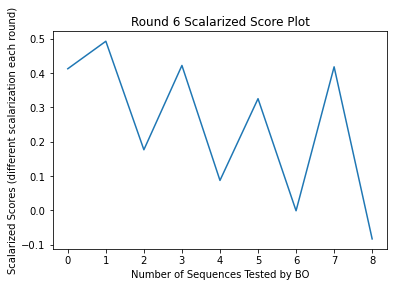

Round  6  mean score:  0.24968615188051396
Random Scalarization (Lambda):  [0.50009545 0.05607921 0.3034119  0.14041344]
[ 0.20700302 -0.02286375 -1.92904897] -suggested new point
Peak Memory Used This Round:  312780703
3.655298805236817
ETA:  109  seconds
------------------------------------------------------------------------



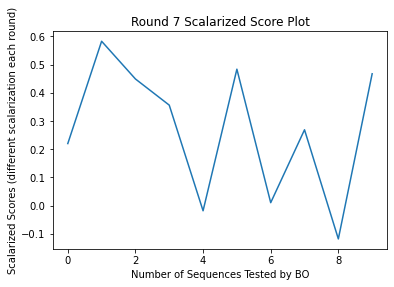

Round  7  mean score:  0.27011214298860653
Random Scalarization (Lambda):  [0.11457791 0.19644388 0.40207574 0.28690247]
[-1.36615662 -2.67108094  0.24141118] -suggested new point
Peak Memory Used This Round:  344708606
3.4064068764448163
ETA:  102  seconds
------------------------------------------------------------------------



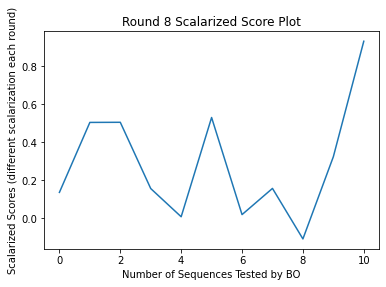

Round  8  mean score:  0.2882791736602252
Random Scalarization (Lambda):  [0.18198979 0.19703977 0.16810222 0.45286821]
[-0.02218152  0.06379991 -0.43013188] -suggested new point
Peak Memory Used This Round:  376663895
3.2411227067311605
ETA:  97  seconds
------------------------------------------------------------------------



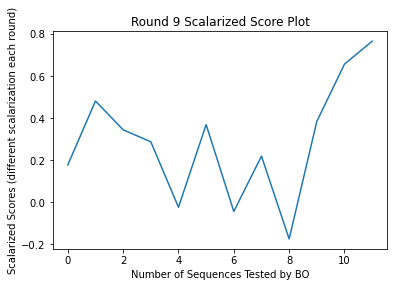

Round  9  mean score:  0.28676515490626925
Random Scalarization (Lambda):  [0.08561446 0.2951557  0.30503573 0.3141941 ]
[ 0.82663269  1.42378977 -1.60690093] -suggested new point
Peak Memory Used This Round:  408687701
3.084421579837799
ETA:  92  seconds
------------------------------------------------------------------------



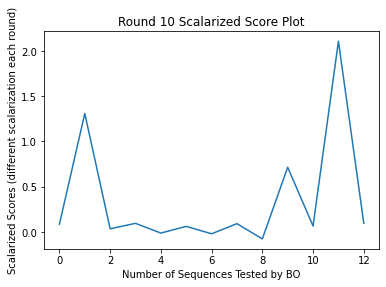

Round  10  mean score:  0.34899328011124453
Random Scalarization (Lambda):  [0.13425315 0.79690343 0.02602947 0.04281395]
[-0.16085856 -0.82970502 -1.23504089] -suggested new point
Peak Memory Used This Round:  440692723
2.9344062949671894
ETA:  88  seconds
------------------------------------------------------------------------



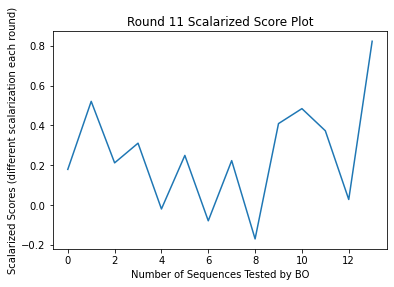

Round  11  mean score:  0.2523658170952358
Random Scalarization (Lambda):  [0.10878131 0.2022605  0.36903793 0.31992027]
[-0.76748107 -0.01423864  0.30551133] -suggested new point
Peak Memory Used This Round:  472710081
2.7954779512352412
ETA:  83  seconds
------------------------------------------------------------------------



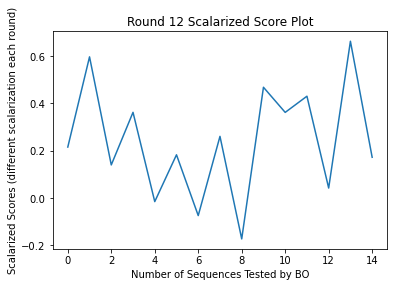

Round  12  mean score:  0.24233890454386672
Random Scalarization (Lambda):  [0.12626447 0.22357185 0.39993695 0.25022673]
[-0.54966671 -1.68884868 -1.71713734] -suggested new point
Peak Memory Used This Round:  504709932
2.6950278172126185
ETA:  80  seconds
------------------------------------------------------------------------



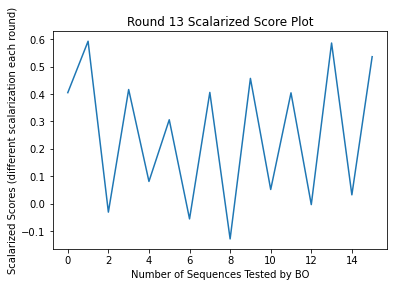

Round  13  mean score:  0.25349995103752915
Random Scalarization (Lambda):  [0.433966   0.08483686 0.42235927 0.05883786]
[ 0.27142073 -0.13009317  0.49267722] -suggested new point
Peak Memory Used This Round:  536776568
2.6234075444085256
ETA:  78  seconds
------------------------------------------------------------------------



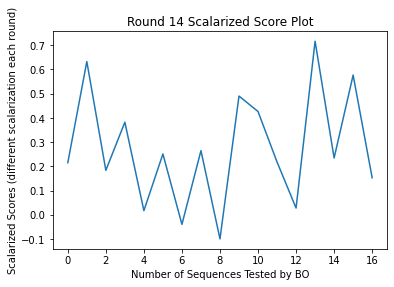

Round  14  mean score:  0.27351467722093004
Random Scalarization (Lambda):  [0.23672343 0.02650044 0.45705355 0.27972259]
[ 0.4734212   0.78893122 -1.45061731] -suggested new point
Peak Memory Used This Round:  568827827
2.4998135630289715
ETA:  74  seconds
------------------------------------------------------------------------



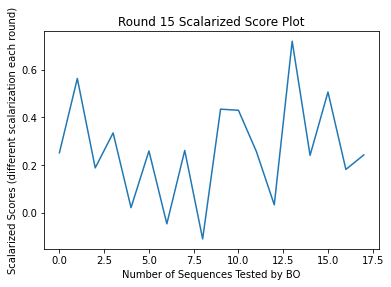

Round  15  mean score:  0.2648255045610458
Random Scalarization (Lambda):  [0.28351743 0.0376599  0.40702373 0.27179893]
[-0.23125238  0.02116402  0.194991  ] -suggested new point
Peak Memory Used This Round:  600689291
2.3565789610147476
ETA:  70  seconds
------------------------------------------------------------------------



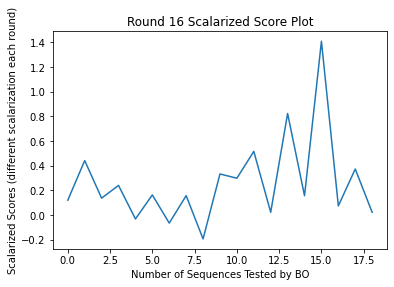

Round  16  mean score:  0.26323794625616254
Random Scalarization (Lambda):  [0.06033777 0.44303013 0.30626519 0.19036691]
[-1.56234369 -0.02744691 -0.270967  ] -suggested new point
Peak Memory Used This Round:  632799825
2.192169064166499
ETA:  65  seconds
------------------------------------------------------------------------



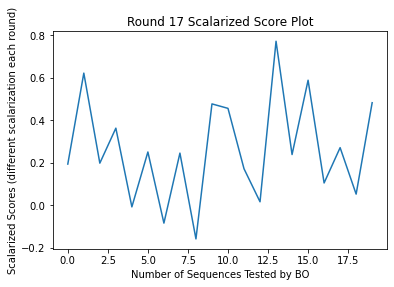

Round  17  mean score:  0.26207309418488195
Random Scalarization (Lambda):  [0.13133261 0.13398114 0.42852116 0.3061651 ]
[1.21595177 0.16130966 0.4722418 ] -suggested new point
Peak Memory Used This Round:  664739029
2.048701721209067
ETA:  61  seconds
------------------------------------------------------------------------



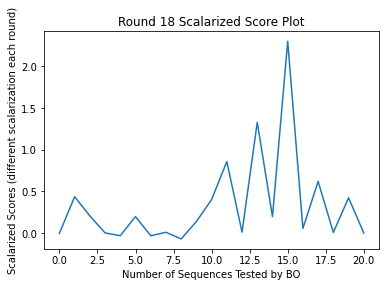

Round  18  mean score:  0.3348827495526294
Random Scalarization (Lambda):  [0.03189053 0.69397788 0.01400168 0.26012991]
[-0.37449749 -0.42322895  1.34201097] -suggested new point
Peak Memory Used This Round:  696735008
1.906325882359555
ETA:  57  seconds
------------------------------------------------------------------------



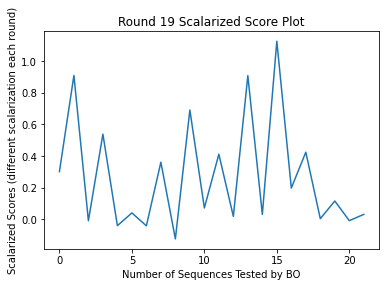

Round  19  mean score:  0.27039275292008874
Random Scalarization (Lambda):  [0.0238433  0.31900693 0.58472743 0.07242234]
[-0.60315362 -0.6069307   2.32608784] -suggested new point
Peak Memory Used This Round:  728667910
1.7340933108329775
ETA:  52  seconds
------------------------------------------------------------------------



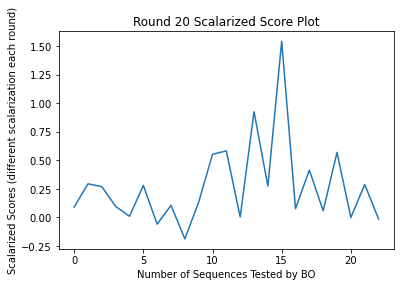

Round  20  mean score:  0.27419152816780834
Random Scalarization (Lambda):  [0.12074294 0.44931233 0.08037425 0.34957048]
[ 0.45925006  0.80878591 -2.72118928] -suggested new point
Peak Memory Used This Round:  760713388
1.58583264502268
ETA:  47  seconds
------------------------------------------------------------------------



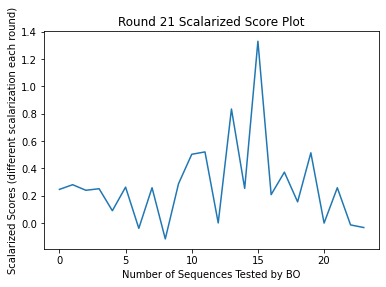

Round  21  mean score:  0.2779551094957353
Random Scalarization (Lambda):  [0.26728759 0.38220827 0.03856024 0.3119439 ]
[-0.83838922 -0.41239033  3.05998654] -suggested new point
Peak Memory Used This Round:  792717222
1.4358034502376211
ETA:  43  seconds
------------------------------------------------------------------------



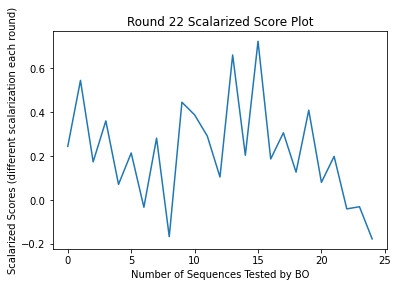

Round  22  mean score:  0.22261024790337147
Random Scalarization (Lambda):  [0.19316276 0.19873704 0.37102615 0.23707404]
[0.02745169 1.60139398 1.26133074] -suggested new point
Peak Memory Used This Round:  824668363
1.2868965867636863
ETA:  38  seconds
------------------------------------------------------------------------



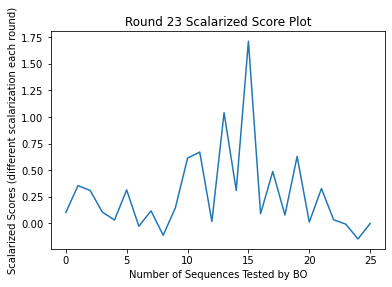

Round  23  mean score:  0.2776113714965539
Random Scalarization (Lambda):  [0.12332867 0.46921936 0.04894104 0.35851093]
[-2.294059    0.15219603 -0.91520886] -suggested new point
Peak Memory Used This Round:  856737336
1.131517187092039
ETA:  33  seconds
------------------------------------------------------------------------



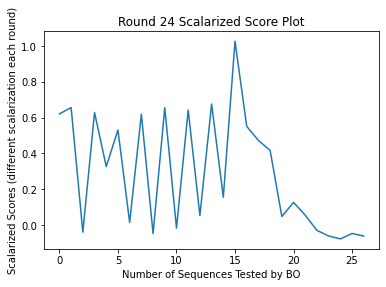

Round  24  mean score:  0.2918717026032036
Random Scalarization (Lambda):  [0.56873795 0.27267368 0.15697929 0.00160908]
[-0.09198613 -1.19165907 -1.75148846] -suggested new point
Peak Memory Used This Round:  888693197
0.973424543380737
ETA:  29  seconds
------------------------------------------------------------------------



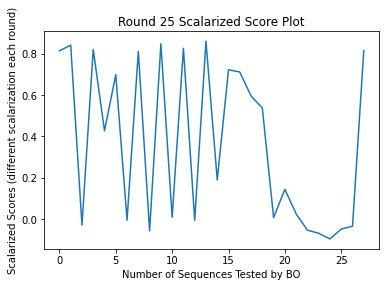

Round  25  mean score:  0.36757349540323
Random Scalarization (Lambda):  [0.77574122 0.19711002 0.00775114 0.01939762]
[-0.77122731 -1.08722709 -1.45933408] -suggested new point
Peak Memory Used This Round:  920675465
0.816275405578124
ETA:  24  seconds
------------------------------------------------------------------------



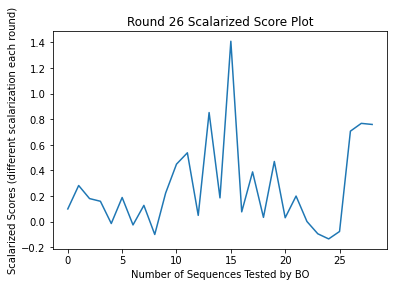

Round  26  mean score:  0.2670085699045414
Random Scalarization (Lambda):  [0.04295475 0.38565551 0.18982401 0.38156573]
[0.14326366 2.25103586 1.62331882] -suggested new point
Peak Memory Used This Round:  952760627
0.65051906844716
ETA:  19  seconds
------------------------------------------------------------------------



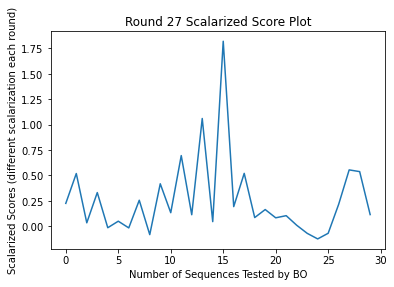

Round  27  mean score:  0.26416015880020854
Random Scalarization (Lambda):  [0.03605263 0.48198759 0.34650677 0.13545301]
[ 0.55041686  1.61679823 -3.03510303] -suggested new point
Peak Memory Used This Round:  984761175
0.4918906756809779
ETA:  14  seconds
------------------------------------------------------------------------



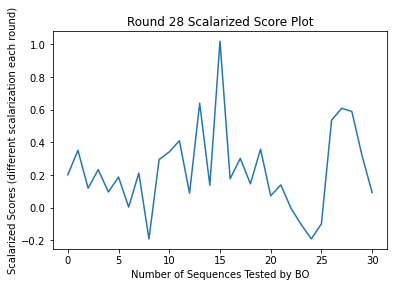

Round  28  mean score:  0.22835637247371285
Random Scalarization (Lambda):  [0.18935633 0.27162174 0.23711341 0.30190853]
[-0.74345833 -2.37397544 -1.28089237] -suggested new point
Peak Memory Used This Round:  1016744226
0.3286352141150112
ETA:  9  seconds
------------------------------------------------------------------------



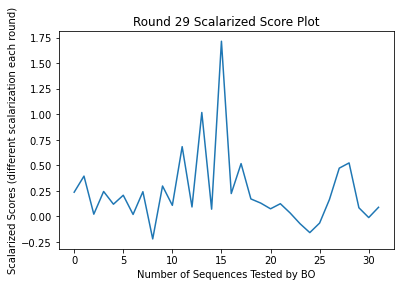

Round  29  mean score:  0.236252364777555
Random Scalarization (Lambda):  [0.21282843 0.44623554 0.22819708 0.11273896]
[ 0.33976999 -1.27784122 -2.85412185] -suggested new point
Peak Memory Used This Round:  1048783411
0.16554014152950708
ETA:  4  seconds
------------------------------------------------------------------------



In [76]:
num_rounds = 30
bayesian_optimizer.sequences = initial_sequences
bayesian_optimizer.run_BO(num_rounds)

# Plotting and Analysis #
The *ploting.ipynb* has some example code to do preliminary analysis. The scores of each round are saved in the data directory. 

VAE, DCA, and functionality are reported as costs, so to retrieve the probabilites, one must multiply these columns by negative one